In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Load your dataset (adjust the file path as needed)
data = pd.read_csv('C:\\Users\\binuraa\\Documents\\Cluster13.csv', parse_dates=['Date'], index_col='Date')

# Clean column names to remove any trailing/leading spaces
data.columns = data.columns.str.strip()

# Create a new DataFrame for the log-transformed data
log_data = data.copy()

# Apply log transformation to all numeric columns in the new DataFrame
for col in log_data.columns:
    if log_data[col].dtype in ['float64', 'int64']: 
        log_data[col] = np.log(log_data[col])

# Check for non-positive values
for col in data.columns:  
    log_data[col] = log_data[col] + 1  

# Check the log-transformed data
print(log_data.head())

        Revenue MoM  Pre Gross MoM  Mean User Throughput Mbps  \
Date                                                            
21-Jul    20.696289      11.283977                   2.691939   
21-Aug    20.534023      10.787796                   2.693779   
21-Sep    20.560986      10.737433                   2.597365   
21-Oct    20.637951      11.277840                   2.675226   
21-Nov    20.480899      11.326629                   2.669592   

        AVERAGE VOICE MINUTES PER USER  Average Media Spend  Exchange Rate  \
Date                                                                         
21-Jul                        6.564405            15.185460       6.293305   
21-Aug                        6.747161            15.251683       6.293305   
21-Sep                        6.701947            15.264400       6.293305   
21-Oct                        6.504762            15.587410       6.298317   
21-Nov                        6.423054            15.517309       6.310740  

C:\Users\binuraa\AppData\Local\Temp\ipykernel_18808\1487409116.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('C:\\Users\\binuraa\\Documents\\Cluster13.csv', parse_dates=['Date'], index_col='Date')
C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
print(log_data.isnull().sum())

Revenue MoM                       0
Pre Gross MoM                     0
Mean User Throughput Mbps         0
AVERAGE VOICE MINUTES PER USER    0
Average Media Spend               0
Exchange Rate                     0
Headline Inflation                4
Traffic                           0
Average Data Usage                0
dtype: int64


In [4]:
log_data['Headline Inflation'] = log_data['Headline Inflation'].interpolate(method='linear')

In [5]:
print(log_data.isnull().sum())

Revenue MoM                       0
Pre Gross MoM                     0
Mean User Throughput Mbps         0
AVERAGE VOICE MINUTES PER USER    0
Average Media Spend               0
Exchange Rate                     0
Headline Inflation                0
Traffic                           0
Average Data Usage                0
dtype: int64


In [6]:
print(len(log_data))

156


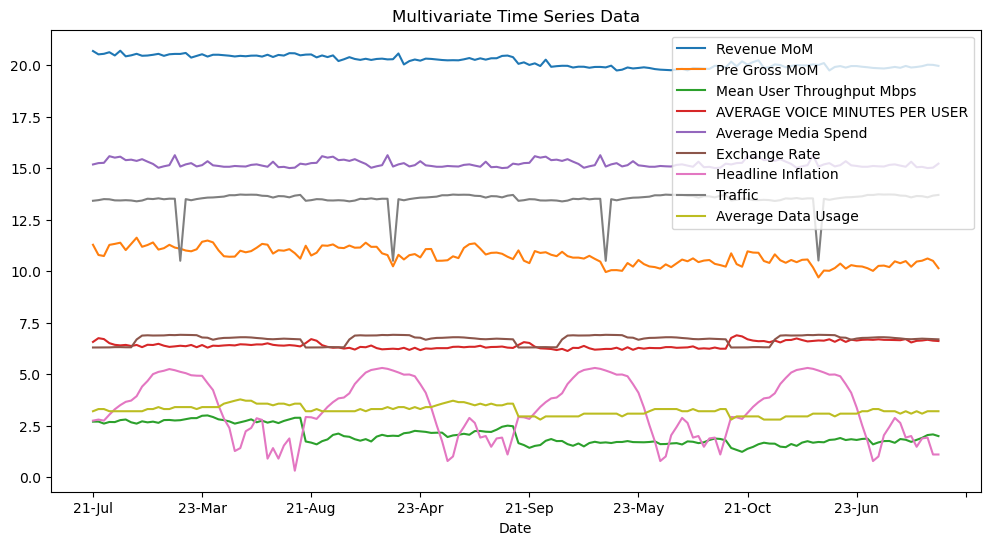

In [7]:
# Plot the time series data
log_data.plot(figsize=(12, 6))
plt.title('Multivariate Time Series Data')
plt.show()

In [8]:
def check_stationarity(series):
    result = adfuller(series.dropna()) 
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return "Stationary" if result[1] < 0.05 else "Non-Stationary"
   
for col in log_data.columns:
    print(f"{col}: {check_stationarity(log_data[col])}")

ADF Statistic: -1.5377, p-value: 0.5148
Revenue MoM: Non-Stationary
ADF Statistic: -1.5386, p-value: 0.5143
Pre Gross MoM: Non-Stationary
ADF Statistic: -1.7125, p-value: 0.4247
Mean User Throughput Mbps: Non-Stationary
ADF Statistic: -1.0715, p-value: 0.7263
AVERAGE VOICE MINUTES PER USER: Non-Stationary
ADF Statistic: -3.3234, p-value: 0.0139
Average Media Spend: Stationary
ADF Statistic: -4.1649, p-value: 0.0008
Exchange Rate: Stationary
ADF Statistic: -5.6219, p-value: 0.0000
Headline Inflation: Stationary
ADF Statistic: -11.8825, p-value: 0.0000
Traffic: Stationary
ADF Statistic: -2.3138, p-value: 0.1676
Average Data Usage: Non-Stationary


In [9]:
# Function to make a column stationary with additional diagnostics
def make_stationary(log_data, column, max_diff=3):
    """
    Apply differencing to make a time series stationary.
    max_diff: Maximum number of differencing to apply.
    """
    diff_series = log_data[column]
    original_count = len(diff_series.dropna()) 
    for i in range(max_diff):
        diff_series = diff_series.diff().dropna()
        # Check stationarity after differencing
        p_value = adfuller(diff_series)[1]
        if p_value <= 0.05:  
            print(f"Column '{column}' is now stationary after {i+1} differencing(s).")
            break
    else:
        print(f"Column '{column}' did not become stationary after {max_diff} differencings.")
    return diff_series

In [10]:
# Apply differencing where necessary and store results in a dictionary
stationary_data = {}
for col in log_data.columns:
    p_value = adfuller(log_data[col])[1]
    if p_value > 0.05: 
        print(f"Converting {col} to stationary:")
        stationary_data[col] = make_stationary(log_data, col)
    else:
        print(f"Column '{col}' is already stationary.")

Converting Revenue MoM to stationary:
Column 'Revenue MoM' is now stationary after 1 differencing(s).
Converting Pre Gross MoM to stationary:
Column 'Pre Gross MoM' is now stationary after 1 differencing(s).
Converting Mean User Throughput Mbps to stationary:
Column 'Mean User Throughput Mbps' is now stationary after 1 differencing(s).
Converting AVERAGE VOICE MINUTES PER USER to stationary:
Column 'AVERAGE VOICE MINUTES PER USER' is now stationary after 1 differencing(s).
Column 'Average Media Spend' is already stationary.
Column 'Exchange Rate' is already stationary.
Column 'Headline Inflation' is already stationary.
Column 'Traffic' is already stationary.
Converting Average Data Usage to stationary:
Column 'Average Data Usage' is now stationary after 1 differencing(s).


In [11]:
# Sanitize column names
log_data.columns = log_data.columns.str.replace(r'[^\w]', '_', regex=True)

<Figure size 1000x600 with 0 Axes>

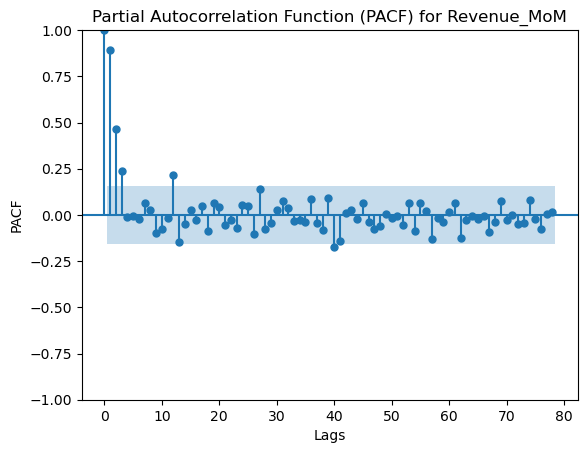

In [12]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Revenue_MoM'], lags=max_lags, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF) for Revenue_MoM')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

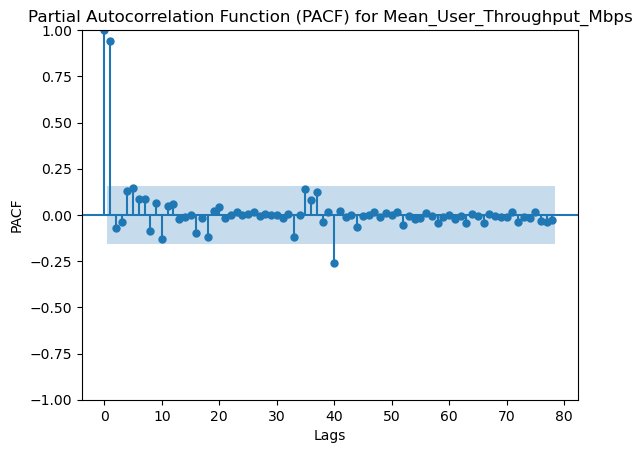

In [13]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Mean_User_Throughput_Mbps'], lags=max_lags, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF) for Mean_User_Throughput_Mbps')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

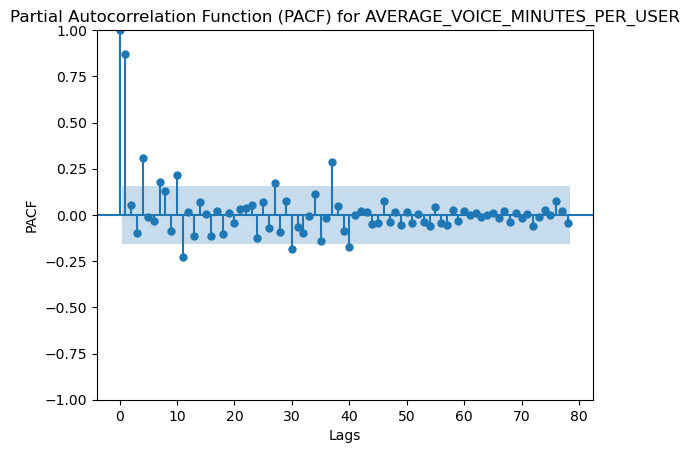

In [14]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['AVERAGE_VOICE_MINUTES_PER_USER'], lags=max_lags, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF) for AVERAGE_VOICE_MINUTES_PER_USER')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

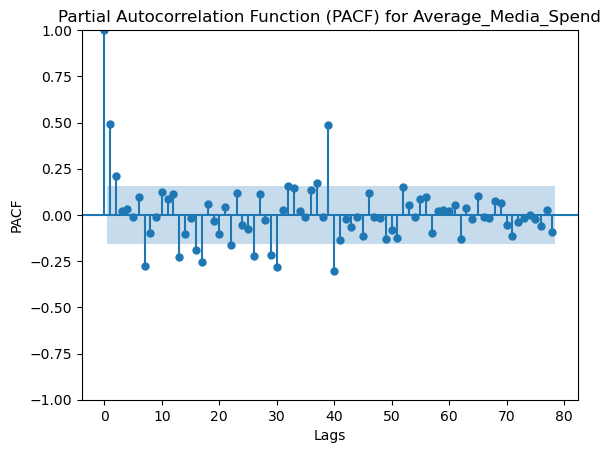

In [15]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Average_Media_Spend'], lags=max_lags, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF) for Average_Media_Spend')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

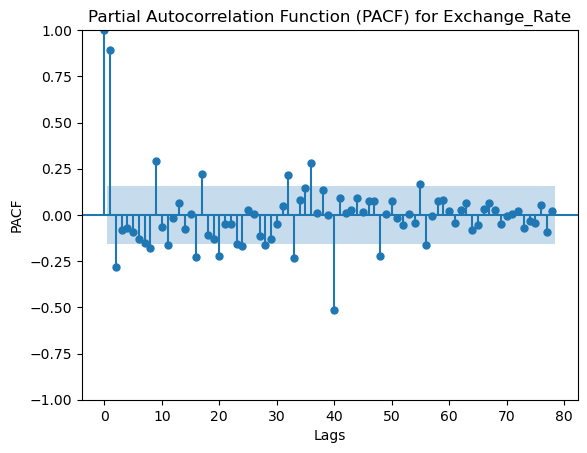

In [16]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Exchange_Rate'], lags=max_lags, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF) for Exchange_Rate')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

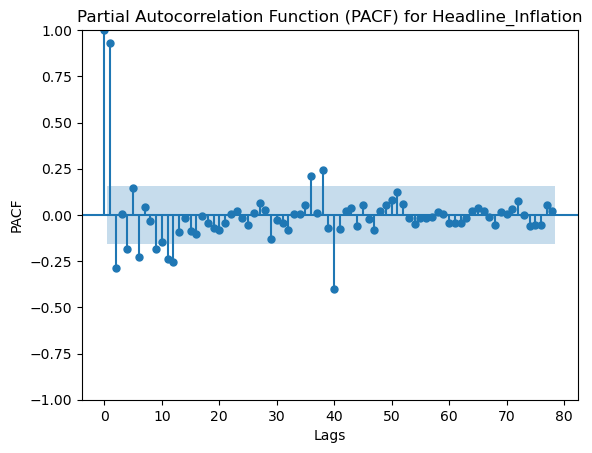

In [17]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Headline_Inflation'], lags=max_lags, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF) for Headline_Inflation')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

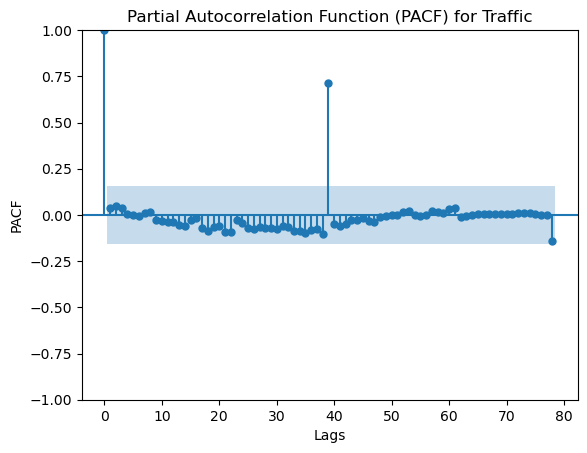

In [18]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Traffic'], lags=max_lags, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF) for Traffic')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

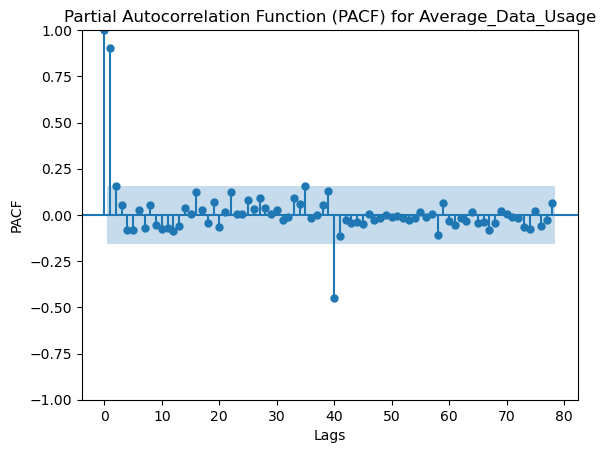

In [19]:
# Determine the maximum allowable lags (50% of the dataset size)
max_lags = len(log_data) // 2

# Plot PACF for the dependent variable
plt.figure(figsize=(10, 6))
plot_pacf(log_data['Average_Data_Usage'], lags=max_lags, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF) for Average_Data_Usage')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [20]:
# Specify the dependent and independent variables
dependent_variable = log_data['Revenue_MoM']
independent_variables = log_data[
    [
        'Mean_User_Throughput_Mbps',
        'AVERAGE_VOICE_MINUTES_PER_USER',
        'Average_Media_Spend',
        'Exchange_Rate',
        'Headline_Inflation',
        'Traffic',
        'Average_Data_Usage',
    ]
]

C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                   ARDL Model Results                                   
Dep. Variable:                      Revenue_MoM   No. Observations:                  124
Model:             ARDL(3, 2, 1, 3, 2, 2, 3, 2)   Log Likelihood                 152.374
Method:                         Conditional MLE   S.D. of innovations              0.069
Date:                          Fri, 06 Dec 2024   AIC                           -250.748
Time:                                  08:31:08   BIC                           -175.262
Sample:                                       3   HQIC                          -220.091
                                            124                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 9.1539      3.535      2.590      0.011       

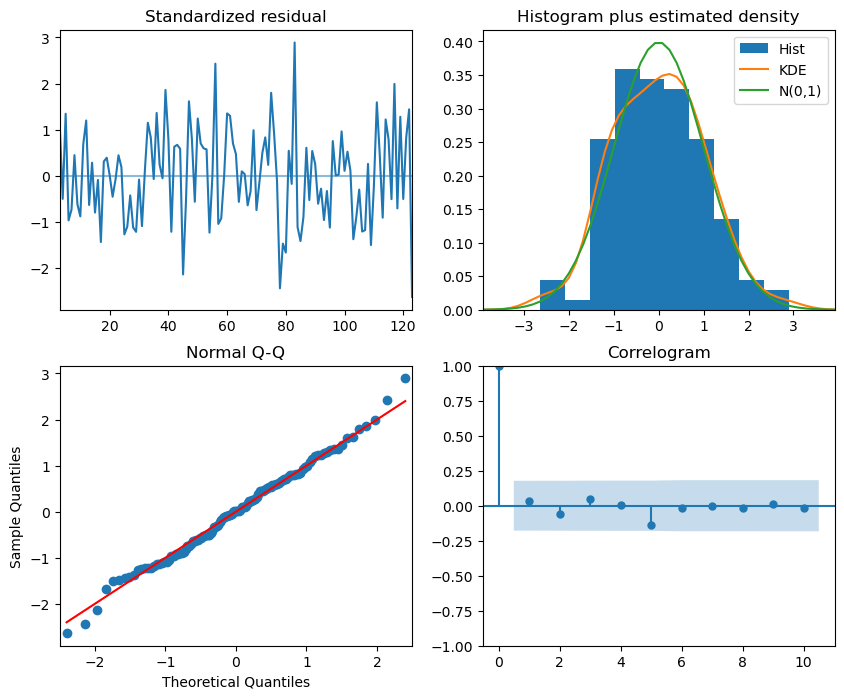

R-squared on Test Data: -4.428112115880846


C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\binuraa\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [21]:
# Specify lag order for the dependent variable
dependent_lag = 3 

exog_lag_order = {
    'Mean_User_Throughput_Mbps': 2, 
    'AVERAGE_VOICE_MINUTES_PER_USER': 1, 
    'Average_Media_Spend':3,
    'Exchange_Rate':2,
    'Headline_Inflation':2,
    'Traffic':3,
    'Average_Data_Usage':2,
}
train_dep, test_dep, train_indep, test_indep = train_test_split(
    dependent_variable,
    independent_variables,
    test_size=0.2,
    shuffle=False
)

# Initialize the ARDL model
selected_model = ARDL(
    endog=train_dep,
    lags=dependent_lag,
    exog=train_indep,
    order=exog_lag_order,
    trend='c'
)

# Fit the model
fitted_model = selected_model.fit()

# Display the summary
print(fitted_model.summary())

# Diagnostic plots
fitted_model.plot_diagnostics(figsize=(10, 8))
plt.show()

from sklearn.metrics import r2_score

# Make predictions on the test set
test_predictions = fitted_model.predict(
    start=len(train_dep),  # Start where the test set begins
    end=len(dependent_variable) - 1,  # End at the last observation
    exog_oos=test_indep  # Provide the test independent variables
)


# Calculate R-squared value
R_squared = r2_score(test_dep, test_predictions)

print(f"R-squared on Test Data: {R_squared}")


In [22]:
# Select only independent variables (drop dependent variable)
independent_variables_vif = independent_variables.copy()

# Add a constant term for the intercept
independent_variables_vif = sm.add_constant(independent_variables_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_variables_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(independent_variables_vif.values, i)
    for i in range(independent_variables_vif.shape[1])
]

# Display VIF results
print(vif_data)

                         Variable           VIF
0                           const  27994.973308
1       Mean_User_Throughput_Mbps      2.413573
2  AVERAGE_VOICE_MINUTES_PER_USER      1.272056
3             Average_Media_Spend      1.810045
4                   Exchange_Rate      2.114724
5              Headline_Inflation      2.514564
6                         Traffic      1.151999
7              Average_Data_Usage      4.054150


In [23]:
print(log_data.isnull().sum())

Revenue_MoM                       0
Pre_Gross_MoM                     0
Mean_User_Throughput_Mbps         0
AVERAGE_VOICE_MINUTES_PER_USER    0
Average_Media_Spend               0
Exchange_Rate                     0
Headline_Inflation                0
Traffic                           0
Average_Data_Usage                0
dtype: int64


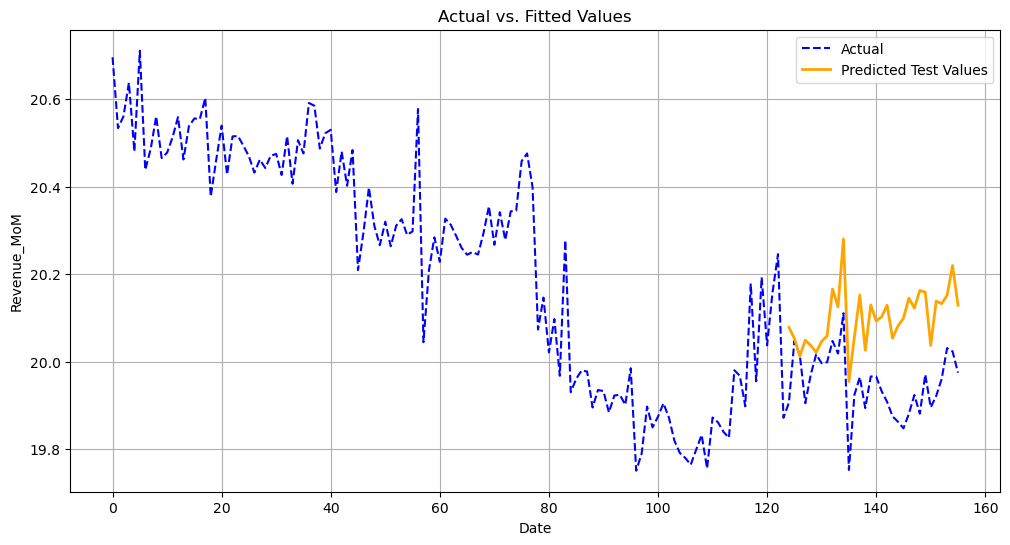

In [24]:
# Extract the fitted values and residuals
fitted_values = fitted_model.fittedvalues
actual_values = dependent_variable

plt.figure(figsize=(12, 6))
plt.plot(actual_values.values, label='Actual', color='blue',  linestyle='--',) 
plt.plot(test_predictions, label='Predicted Test Values', color='orange', linewidth=2)
plt.title('Actual vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Revenue_MoM')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Calculate RMSE
mse = mean_squared_error(test_dep, test_predictions)

print(f" Mean Square Error (RMSE) on Test Data: {mse}")

 Mean Square Error (RMSE) on Test Data: 0.027766912149590314


In [26]:
dates = pd.date_range(start="2021-01-01", periods=156, freq='D')

log_data = pd.DataFrame({'Date': dates, 'Revenue_MoM': actual_values})
predicted_values = pd.Series(test_predictions, name='Predicted_Revenue')

# Extract the last 30 actual and predicted values
last_30_dates = log_data['Date'].iloc[-30:]
last_30_actual_values = log_data['Revenue_MoM'].iloc[-30:]
last_30_predicted_values = test_predictions.iloc[-30:]

# Calculate adjusted values and their antilogs
adjusted_actual_values = last_30_actual_values - 1
adjusted_predicted_values = last_30_predicted_values - 1

antilog_actual_values = np.exp(adjusted_actual_values)
antilog_predicted_values = np.exp(adjusted_predicted_values)

# Calculate the difference between antilog values
difference_values = antilog_actual_values - antilog_predicted_values

# Create a DataFrame for the table
table = pd.DataFrame({
    'Date': last_30_dates,
    'Adjusted Actual Values': adjusted_actual_values,
    'Adjusted Predicted Values': adjusted_predicted_values,
    'Antilog Actual Values': antilog_actual_values,
    'Antilog Predicted Values': antilog_predicted_values,
    'Difference': difference_values
})

# Display the table
import ace_tools as tools
tools.display_dataframe_to_user(name="Last 30 Actual and Predicted Revenue Values Table", dataframe=table)


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
last_30_revenue_values = log_data['Revenue_MoM'].iloc[-30:]
print("Last 30 Actual Revenue Values:")
print(last_30_revenue_values)

In [ ]:
# Extract the last 30 predicted values from test_predictions
last_30_predicted_values = test_predictions.iloc[-30:]
print("\nLast 30 Predicted Values:")
print(last_30_predicted_values)

In [ ]:
residuals = fitted_model.resid
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals.values, label='Residuals', color='red', linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals from ARDL Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot cumulative sum of residuals
cumsum_residuals = fitted_model.resid.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(cumsum_residuals.values, label='CUSUM')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.axhline(y=1.96 * cumsum_residuals.std(), color='red', linestyle='--', label='Upper Bound (95%)')
plt.axhline(y=-1.96 * cumsum_residuals.std(), color='red', linestyle='--', label='Lower Bound (95%)')
plt.title('CUSUM Test')
plt.legend()
plt.show()

In [ ]:
# # Add constant term for intercept
# X = sm.add_constant(X)

# # Fit the OLS regression model
# model = sm.OLS(y, X).fit()

# # Perform the Breusch-Godfrey test (VOL Test)
# bg_test = sm.stats.diagnostic.acorr_breusch_godfrey(model, nlags=2) 
# print(f"LM Statistic: {bg_test[0]}")
# print(f"p-value: {bg_test[1]}")

# # Interpretation(Significance level 5%)
# if bg_test[1] < 0.05:
#     print("Reject the null hypothesis: Residuals are autocorrelated.")
# else:
#     print("Fail to reject the null hypothesis: No evidence of autocorrelation.")

In [ ]:
# from sklearn.metrics import r2_score

# # Actual and predicted values
# y_actual = dependent_variable.values
# y_pred = fitted_values.values

# # Calculate R-squared
# r_squared = r2_score(y_actual, y_pred)
# print(f"R-squared: {r_squared}")

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

bg_test = acorr_breusch_godfrey(fitted_model)
print(f"Breusch-Godfrey Test:\nLM Statistic: {bg_test[0]}, p-value: {bg_test[1]}")

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(fitted_model.resid, fitted_model.model.exog)
print(f"Breusch-Pagan Test:\nLM Statistic: {bp_test[0]}, p-value: {bp_test[1]}")


In [ ]:
from statsmodels.stats.stattools import jarque_bera

# Perform Jarque-Bera test
jb_test = jarque_bera(fitted_model.resid)
print(f"Jarque-Bera Test:\nStatistic: {jb_test[0]}, p-value: {jb_test[1]}")


In [ ]:
# print(model_selection)
# print(model_selection.selected_orders)

In [ ]:
# from statsmodels.tsa.ardl import ARDL

# # Specify the lag order for dependent and independent variables
# manual_lags = (1, 0)  # Example: lag 1 for the dependent variable, lag 0 for independent variables

# # Define and fit the ARDL model
# selected_model = ARDL(
#     endog=dependent_variable,  # Your dependent variable
#     exog=independent_variables,  # Your independent variables
#     order=manual_lags,  # Lag order
#     trend='c'  # Include a constant term
# )

# # Fit the model
# fitted_model = selected_model.fit()

# # Display the model summary
# print(fitted_model.summary())

# # Diagnostic plots (optional)
# fitted_model.plot_diagnostics(figsize=(10, 8))
# plt.show()


In [ ]:
# print(model_selection)

In [ ]:
# from statsmodels.tsa.ardl import bounds_test

# bounds_test_result = bounds_test(
#     ardl_model,  # The fitted ARDL model
#     case="III"   # Case options: 'I', 'II', 'III', 'IV', 'V' (based on deterministic trends)
# )
# print(bounds_test_result)

In [ ]:
# from statsmodels.tsa.ardl import ardl_bounds

# # Perform the Bounds Test
# bounds_test_results = bounds_test(
#     model,  # Fitted ARDL model
#     case=3  # Case 3: unrestricted intercept, no trend
# )

# # Display Bounds Test results
# print("\nBounds Test Results:")
# print(bounds_test_results)

# # Extract critical values for interpretation
# critical_values = bounds_test_results['critical_values']
# f_statistic = bounds_test_results['statistic']

# print(f"\nF-statistic: {f_statistic}")
# print("Critical Values:")
# for significance_level, bounds in critical_values.items():
#     print(f"Significance Level {significance_level * 100}%: I(0)={bounds[0]}, I(1)={bounds[1]}")

# # Interpretation
# if f_statistic > max(critical_values[0.05]):  # Compare with 5% upper bound
#     print("\nConclusion: Evidence of cointegration (reject null hypothesis).")
# elif f_statistic < min(critical_values[0.10]):  # Compare with 10% lower bound
#     print("\nConclusion: No evidence of cointegration (fail to reject null hypothesis).")
# else:
#     print("\nConclusion: Inconclusive results.")


In [ ]:
# log_data[features + ['Revenue_MoM']]

In [ ]:
# # Select the lag order for ARDL
# selected_order = ardl_select_order(endog=y, exog=X, maxlag=3, maxorder=2, ic='aic') 
# print(f"Selected ARDL order (lags): {selected_order.model}")

# # Fit the ARDL model
# model = selected_order.model.fit()

In [ ]:
# print(model.summary())

In [ ]:
# # Add constant term for intercept
# X = sm.add_constant(X)

# # Fit the OLS regression model
# model = sm.OLS(y, X).fit()

# # Perform the Breusch-Godfrey test (VOL Test)
# bg_test = sm.stats.diagnostic.acorr_breusch_godfrey(model, nlags=2) 
# print(f"LM Statistic: {bg_test[0]}")
# print(f"p-value: {bg_test[1]}")

# # Interpretation(Significance level 5%)
# if bg_test[1] < 0.05:
#     print("Reject the null hypothesis: Residuals are autocorrelated.")
# else:
#     print("Fail to reject the null hypothesis: No evidence of autocorrelation.")